# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Halida Fiadnin
- **Email:** halidaafiadnin@gmail.com
- **ID Dicoding:** halidafi

## Import Semua Packages/Library yang Digunakan

In [21]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image
import imageio
import cv2
from skimage.util import img_as_ubyte
from skimage.transform import AffineTransform, warp, rotate, resize
from skimage.filters import gaussian
from skimage import exposure
from skimage.exposure import adjust_gamma

In [22]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

In [37]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hldfiadn","key":"5e292f8648fa04f386ce49b697f4e3d6"}'}

In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!cat ~/.kaggle/kaggle.json

{"username":"hldfiadn","key":"5e292f8648fa04f386ce49b697f4e3d6"}

In [40]:
"""import shutil, os

for item in os.listdir():
    if item != 'sample_data':  # biarkan folder default Colab
        try:
            shutil.rmtree(item)  # jika folder
        except NotADirectoryError:
            os.remove(item)     # jika file
"""

"import shutil, os\n\nfor item in os.listdir():\n    if item != 'sample_data':  # biarkan folder default Colab\n        try:\n            shutil.rmtree(item)  # jika folder\n        except NotADirectoryError:\n            os.remove(item)     # jika file\n"

In [41]:
os.listdir()

['kaggle.json', 'sample_data']

### Data Loading

In [42]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

### Split Dataset

In [43]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = 'Shoe vs Sandal vs Boot Dataset'
output_dir = 'ShoeDatasetSplit'
dataset_dir = os.path.join(output_dir, 'dataset')
splits = ['train', 'valid', 'test']
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

os.makedirs(dataset_dir, exist_ok=True)

# Salin semua gambar dari source_dir ke dataset_dir per kelas
for cls in os.listdir(source_dir):
    class_path = os.path.join(source_dir, cls)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(dataset_dir, cls)
    os.makedirs(target_class_dir, exist_ok=True)

    for img in os.listdir(class_path):
        src = os.path.join(class_path, img)
        dst = os.path.join(target_class_dir, img)
        shutil.copy(src, dst)

# Split isi dataset/ ke dalam train/valid/test
for cls in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, cls)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_and_valid, test = train_test_split(images, test_size=test_ratio, random_state=42)
    train, valid = train_test_split(train_and_valid, test_size=valid_ratio / (train_ratio + valid_ratio), random_state=42)

    for split_name, split_list in zip(splits, [train, valid, test]):
        split_dir = os.path.join(output_dir, split_name, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_dir, img)
            shutil.copy(src, dst)

In [44]:
base_path = 'ShoeDatasetSplit'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path  = os.path.join(base_path, 'test')

### Data Understanding

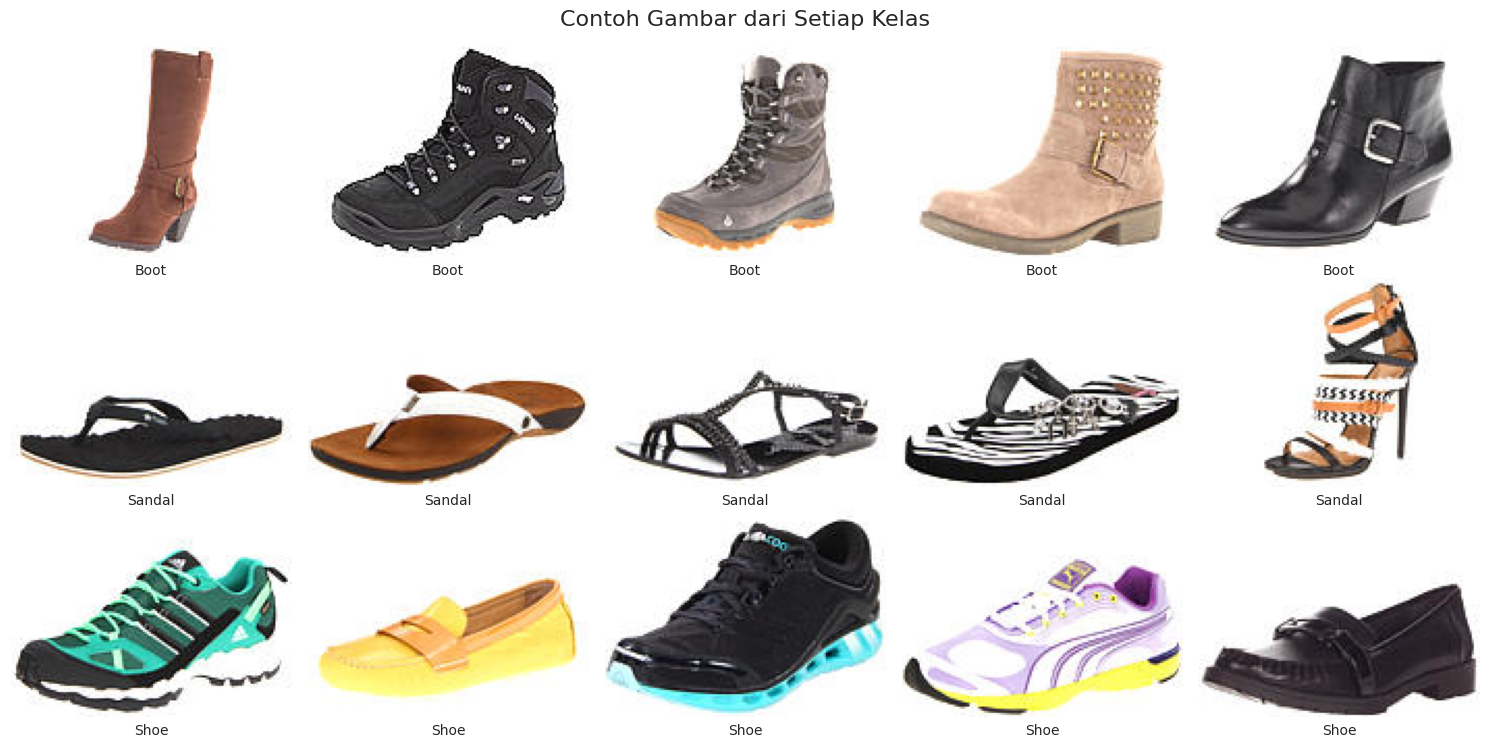

In [45]:
# Kamus untuk menyimpan nama file gambar dari setiap kelas
shoe_images = {}

# Path gabungan dataset
dataset_path = "ShoeDatasetSplit/dataset"

# Mengisi kamus dengan file gambar per kelas
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        shoe_images[class_name] = os.listdir(class_dir)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(shoe_images), 5, figsize=(15, len(shoe_images) * 2.5))

for i, class_name in enumerate(shoe_images.keys()):
    # Ambil 5 gambar secara acak
    images = np.random.choice(shoe_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        try:
            img = Image.open(img_path)  # Tetap dalam format warna RGB
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except:
            print(f"Gagal memuat gambar: {img_path}")

fig.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=16)
fig.tight_layout()
plt.show()

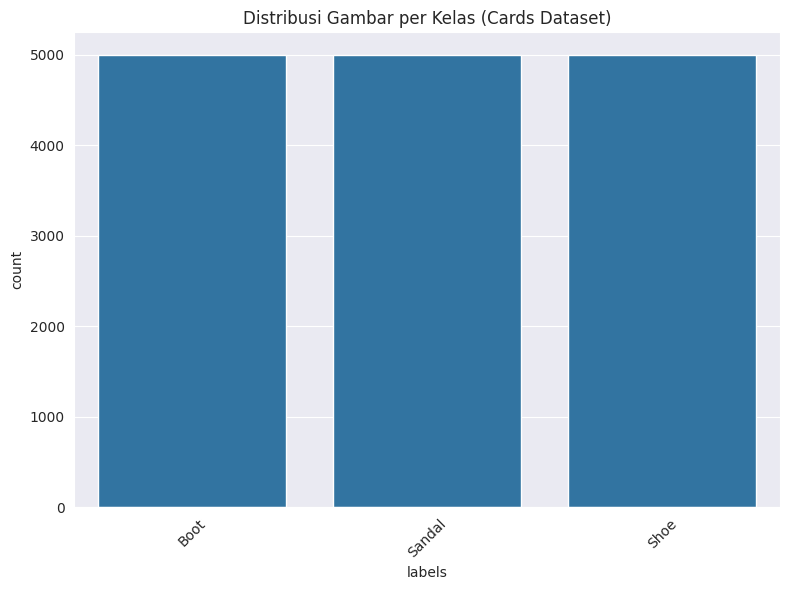

In [46]:
# Buat daftar untuk menyimpan nama file, path lengkap, dan label
file_name = []
labels = []
full_path = []

# Loop untuk mendapatkan path, file, dan label
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", order=distribution_df["labels"].value_counts().index)
plt.title("Distribusi Gambar per Kelas (Cards Dataset)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preprocessing (Data Augmentation)

In [47]:
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

In [48]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down
}

# Path dasar dataset
base_path = "ShoeDatasetSplit/dataset"
classes = ['Shoe', 'Sandal', 'Boot']  # Sesuaikan dengan nama folder kelasmu

images_to_generate = 1000  # Jumlah gambar augmentasi per kelas

for cls in classes:
    images_path = os.path.join(base_path, cls)
    augmented_path = os.path.join(base_path, f"{cls}_augmented")
    os.makedirs(augmented_path, exist_ok=True)

    images = [os.path.join(images_path, im) for im in os.listdir(images_path)]

    i = 1
    while i <= images_to_generate:
        image_path = random.choice(images)
        try:
            original_image = imageio.imread(image_path)
            transformed_image = original_image.copy()
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            new_image_path = os.path.join(augmented_path, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1
        except Exception as e:
            print(f"could not read {image_path}: {e}, skipping.")

<ipython-input-48-f1b6446a8698>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(image_path)


Streaming output truncated to the last 5000 lines.
>     'depth' is 6 (CV_64F)
, skipping.
could not read ShoeDatasetSplit/dataset/Boot/boot (3761).jpg: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)
, skipping.
could not read ShoeDatasetSplit/dataset/Boot/boot (2512).jpg: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelp

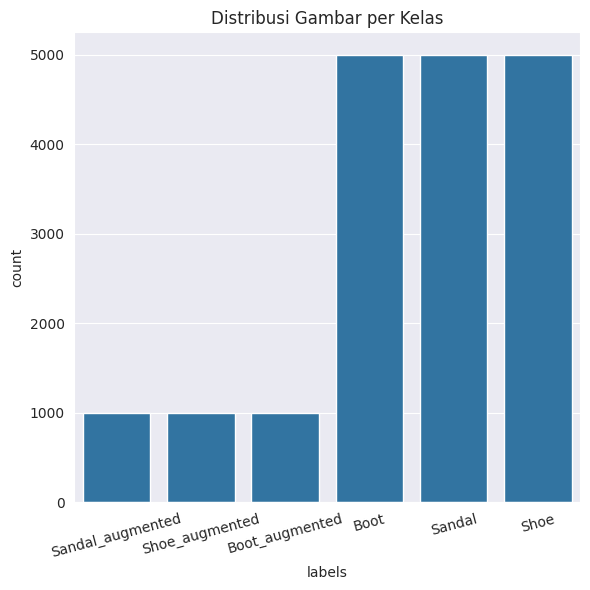

In [50]:
# Definisikan path sumber
shoe_path = "ShoeDatasetSplit/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Looping untuk ambil path, nama file, dan label
for path, subdirs, files in os.walk(shoe_path):
    for name in files:
        if name.lower().endswith((".jpg", ".jpeg", ".png")):  # pastikan hanya file gambar
            full_path.append(os.path.join(path, name))
            label = os.path.basename(os.path.normpath(path))
            labels.append(label)
            file_name.append(name)

# Simpan ke DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, x="labels")
plt.title("Distribusi Gambar per Kelas")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Modelling

### Data Splitting

In [51]:
mypath = 'ShoeDatasetSplit/dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    # Filter hanya folder asli (bukan *_augmented)
    if os.path.basename(path).endswith('_augmented'):
        continue

    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # hanya file gambar
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # label = nama folder
            file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Tampilkan jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Boot,5000
Sandal,5000
Shoe,5000


In [52]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [53]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [54]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   Boot       951
       Sandal    1062
       Shoe       987
train  Boot      4049
       Sandal    3938
       Shoe      4013
dtype: int64 


                                                    path  labels    set
1460       ShoeDatasetSplit/dataset/Boot/boot (1138).jpg    Boot  train
8976   ShoeDatasetSplit/dataset/Sandal/Sandal (1157).jpg  Sandal  train
11474       ShoeDatasetSplit/dataset/Boot/boot (693).jpg    Boot  train
6658   ShoeDatasetSplit/dataset/Sandal/Sandal (1718).jpg  Sandal  train
12834      ShoeDatasetSplit/dataset/Boot/boot (2996).jpg    Boot   test


In [56]:
# Gabungkan df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli (semua gambar sebelum dipisah train/valid/test)
datasource_path = "ShoeDatasetSplit/dataset/"

# Menentukan folder tempat menyimpan dataset yang telah dibagi (jika ada)
dataset_path = "ShoeDatasetSplit/"  # atau ubah jadi "ShoeDatasetSplitFinal/" jika kamu ingin hasil akhir dipisah



set    labels
test   Boot       951
       Sandal    1062
       Shoe       987
train  Boot      4049
       Sandal    3938
       Shoe      4013
dtype: int64 


                                                    path  labels    set
8388        ShoeDatasetSplit/dataset/Shoe/Shoe (510).jpg    Shoe  train
13917  ShoeDatasetSplit/dataset/Sandal/Sandal (1458).jpg  Sandal   test
9834   ShoeDatasetSplit/dataset/Sandal/Sandal (2554).jpg  Sandal  train
10587       ShoeDatasetSplit/dataset/Shoe/Shoe (869).jpg    Shoe  train
10319  ShoeDatasetSplit/dataset/Sandal/Sandal (3058).jpg  Sandal  train


In [57]:
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    # Ambil path file
    file_path = row['path']

    # Jika file tidak ditemukan (misalnya karena path tidak lengkap), coba bangun ulang
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat direktori tujuan jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    # Tentukan path tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

  0%|          | 0/15000 [00:00<?, ?it/s]

### Image Data Generator

In [58]:
# Definisikan direktori training dan test
TRAIN_DIR = "ShoeDatasetSplit/train/"
TEST_DIR = "ShoeDatasetSplit/test/"

# Path tiap kelas
train_shoe = os.path.join(TRAIN_DIR, 'Shoe')
train_sandal = os.path.join(TRAIN_DIR, 'Sandal')
train_boot = os.path.join(TRAIN_DIR, 'Boot')

test_shoe = os.path.join(TEST_DIR, 'Shoe')
test_sandal = os.path.join(TEST_DIR, 'Sandal')
test_boot = os.path.join(TEST_DIR, 'Boot')

# Cetak jumlah gambar per kelas
print("Total number of Shoe images in training set: ", len(os.listdir(train_shoe)))
print("Total number of Sandal images in training set: ", len(os.listdir(train_sandal)))
print("Total number of Boot images in training set: ", len(os.listdir(train_boot)))
print("Total number of Shoe images in test set: ", len(os.listdir(test_shoe)))
print("Total number of Sandal images in test set: ", len(os.listdir(test_sandal)))
print("Total number of Boot images in test set: ", len(os.listdir(test_boot)))

Total number of Shoe images in training set:  4690
Total number of Sandal images in training set:  4672
Total number of Boot images in training set:  4723
Total number of Shoe images in test set:  1577
Total number of Sandal images in test set:  1662
Total number of Boot images in test set:  1563


In [59]:
# Buat ImageDataGenerator tanpa split karena validasi sudah dipisah folder
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path ke folder hasil split
TRAIN_DIR = "ShoeDatasetSplit/train/"
VALID_DIR = "ShoeDatasetSplit/valid/"
TEST_DIR  = "ShoeDatasetSplit/test/"

# Generator untuk masing-masing set
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150,150),
    color_mode="rgb",  # atau "grayscale" jika kamu yakin datanya hitam putih
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    batch_size=32,
    target_size=(150,150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150,150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 14085 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 4802 images belonging to 3 classes.


### Pembangunan Model

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)